In [1]:
require(stringr)
project_name = 'ML-MADNESS'
repo_path = file.path(substr(getwd(),0,gregexpr(pattern = project_name ,
                                                getwd())[[1]][1]-2),
                      project_name)
setwd(repo_path)

Loading required package: stringr



In [64]:
source(file.path(repo_path,'objects','helper_functions.R'))
p = scan(file.path(repo_path,'features/requirements.txt'),what="",sep="\n")
load_all_packages(p)
p = scan(file.path(repo_path,'sagemaker/requirements.txt'),what="",sep="\n")
load_all_packages(p)
slice = dplyr::slice
rename = dplyr::rename

also installing the dependency ‘bitops’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# Sagemaker Settings
sagemaker <- import('sagemaker')
session <- sagemaker$Session()
bucket <- session$default_bucket()
role_arn <- sagemaker$get_execution_role()

In [4]:
source(file.path(repo_path,'features','api_calls.r'))

In [17]:
source(file.path(repo_path,'features','modeling.r'))
boxscores = load_box_score_data()

In [30]:
all_team_data = initial_cleaning(boxscores)

In [33]:
team_info = all_team_data %>%
  ungroup() %>% 
  select(team_id,team_display_name.x) %>% 
  group_by(team_id,team_display_name.x) %>% 
  summarize(APPEARANCES = n()) %>% 
  rename("team_name" = "team_display_name.x") %>% 
  arrange(desc(APPEARANCES))

team_data_refined = all_team_data %>% 
  ungroup() %>% 
  select(-c(team_display_name.x,team_display_name.y))

`summarise()` has grouped output by 'team_id'. You can override using the
`.groups` argument.


In [48]:
source(file.path(repo_path,'features','elo_helper.r'))

In [85]:
names(team_data_refined)

[1] "team_id"              "game_id"              "game_date"           
 [4] "FGM.x"                "FGA.x"                "FG3M.x"              
 [7] "FG3A.x"               "FTM.x"                "FTA.x"               
[10] "offensive_rebounds.x" "defensive_rebounds.x" "assists.x"           
[13] "steals.x"             "blocks.x"             "turnovers.x"         
[16] "team_turnovers.x"     "total_turnovers.x"    "technical_fouls.x"   
[19] "flagrant_fouls.x"     "fouls.x"              "largest_lead.x"      
[22] "home_away.x"          "opponent_id"          "PTS.x"               
[25] "FGM.y"                "FGA.y"                "FG3M.y"              
[28] "FG3A.y"               "FTM.y"                "FTA.y"               
[31] "offensive_rebounds.y" "defensive_rebounds.y" "assists.y"           
[34] "steals.y"             "blocks.y"             "turnovers.y"         
[37] "team_turnovers.y"     "total_turnovers.y"    "technical_fouls.y"   
[40] "flagrant_fouls.y"     "fouls.y"              "largest_lead.y"      
[43] "home_away.y"          "opponent_id.y"        "PTS.y"               
[46] "winning_margin"       "game_total"           "SEASON"              
[49] "APPEARANCE"           "OPP_APPEARANCE"

In [87]:
start_time <- Sys.time()
df = BOOSTED_calculate_relative_elo(team_data_refined = team_data_refined %>% 
                                filter(SEASON==2022),
                            features = c(
                                "PTS.x",
                                "PTS.y",
                                "FG3M.x",
                                "FG3M.y",
                                "offensive_rebounds.x",
                                "defensive_rebounds.x",
                                "turnovers.x",
                                "turnovers.y"
                                
                            ),
                            rename_fs = c("PTS_SCORED",
                                          "PTS_ALLOWED",
                                          "FG3M",
                                          "FG3M_ALLOWED",
                                          "OFFENSIVE_REBOUNDS",
                                          "DEFENSIVE_REBOUNDS",
                                          "TURNOVERS",
                                          "TURNOVERS_FORCED"))
end_time <- Sys.time()
print(paste0('Time elapsed: ',round(as.numeric(difftime(time1 = end_time, time2 = start_time, units = "secs")), 3)))

[1] "Time elapsed: 340.62"


In [97]:
tail(df)

game_date,game_id,team_id,opponent_id,APPEARANCE,OPP_APPEARANCE,PTS.x,PTS.y,FG3M.x,FG3M.y,⋯,TURNOVERS_DEF_ELO,TURNOVERS_ELO_NEXT,TURNOVERS_DEF_ELO_NEXT,TURNOVERS_FORCED_AVG,TURNOVERS_FORCED_SD,TURNOVERS_FORCED_PERF,TURNOVERS_FORCED_ELO,TURNOVERS_FORCED_DEF_ELO,TURNOVERS_FORCED_ELO_NEXT,TURNOVERS_FORCED_DEF_ELO_NEXT
<date>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-04-02,401408634,222,2305,38,39,65,81,13,13,⋯,2025.861,1630.7956,2072.202,10.14286,10.14286,-0.30985915,1677.1371,2025.861,1630.7956,2072.202
2022-04-02,401408634,2305,222,39,38,81,65,13,13,⋯,2075.354,2078.7471,2085.354,11.25000,11.25000,-0.20000000,2088.7472,2075.354,2078.7471,2085.354
2022-04-03,401408635,153,150,38,39,81,77,10,5,⋯,2297.075,836.8268,2382.396,10.14286,10.14286,-0.60563380,922.1481,2297.075,836.8268,2382.396
2022-04-03,401408635,150,153,39,38,77,81,5,10,⋯,2046.418,1153.1016,2062.671,11.25000,11.25000,-0.11111111,1169.3550,2046.418,1153.1016,2062.671
2022-04-05,401408636,153,2305,39,40,69,72,5,6,⋯,2085.354,808.6523,2113.529,11.25000,11.25000,-0.20000000,836.8268,2085.354,808.6523,2113.529
2022-04-05,401408636,2305,153,40,39,72,69,6,5,⋯,2382.396,2091.2277,2369.915,12.00000,12.00000,0.08333333,2078.7471,2382.396,2091.2277,2369.915


In [100]:
predictors = c("PTS_SCORED_ELO",
              "PTS_ALLOWED_ELO",
              "FG3M_ELO",
              "FG3M_ALLOWED_ELO",
              "OFFENSIVE_REBOUNDS_ELO",
              "DEFENSIVE_REBOUNDS_ELO",
              "TURNOVERS_ELO",
              "TURNOVERS_FORCED_ELO",
               "PTS_SCORED_DEF_ELO",
              "PTS_ALLOWED_DEF_ELO",
              "FG3M_DEF_ELO",
              "FG3M_ALLOWED_DEF_ELO",
              "OFFENSIVE_REBOUNDS_DEF_ELO",
              "DEFENSIVE_REBOUNDS_DEF_ELO",
              "TURNOVERS_DEF_ELO",
              "TURNOVERS_FORCED_DEF_ELO"
              )
non_predictors = c('game_date','game_id','team_id','opponent_id')

pre_modeling = df %>% 
            filter(APPEARANCE!=1,
            OPP_APPEARANCE!=1) %>%
            #select(PTS.x,PTS.y,game_date,game_id,team_id,opponent_id,predictors)%>%
            mutate(MARGIN = PTS.x - PTS.y,
                   WIN = ifelse(MARGIN >0,1,0))
modeling = pre_modeling
head(modeling)

game_date,game_id,team_id,opponent_id,APPEARANCE,OPP_APPEARANCE,PTS.x,PTS.y,FG3M.x,FG3M.y,⋯,TURNOVERS_DEF_ELO_NEXT,TURNOVERS_FORCED_AVG,TURNOVERS_FORCED_SD,TURNOVERS_FORCED_PERF,TURNOVERS_FORCED_ELO,TURNOVERS_FORCED_DEF_ELO,TURNOVERS_FORCED_ELO_NEXT,TURNOVERS_FORCED_DEF_ELO_NEXT,MARGIN,WIN
<date>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-11-11,401371575,120,45,2,2,71,64,3,4,⋯,1998.271,14.15044,14.15044,-0.08130081,1994.635,1994.206,1990.570,1998.271,7,1
2021-11-11,401372009,2507,2529,2,2,92,64,11,12,⋯,1996.918,14.15044,14.15044,0.13070669,2013.233,2016.524,2032.839,1996.918,28,1
2021-11-11,401372009,2529,2507,2,2,64,92,12,11,⋯,2020.163,14.15044,14.15044,-0.22263915,1983.476,1986.767,1950.081,2020.163,-28,0
2021-11-11,401371575,45,120,2,2,64,71,4,3,⋯,2009.430,14.15044,14.15044,-0.08130081,2005.794,2005.365,2001.729,2009.430,-7,0
2021-11-12,401372215,111,2247,2,2,64,83,13,12,⋯,1959.962,14.15044,14.15044,-0.50531582,1979.757,1934.692,1954.488,1959.962,-19,0
2021-11-12,401365000,127,2711,2,2,90,46,4,5,⋯,2045.641,14.15044,14.15044,-0.29330832,1983.476,2001.645,1939.480,2045.641,44,1


In [114]:
modeling 

game_date,game_id,team_id,opponent_id,APPEARANCE,OPP_APPEARANCE,PTS.x,PTS.y,FG3M.x,FG3M.y,⋯,TURNOVERS_DEF_ELO_NEXT,TURNOVERS_FORCED_AVG,TURNOVERS_FORCED_SD,TURNOVERS_FORCED_PERF,TURNOVERS_FORCED_ELO,TURNOVERS_FORCED_DEF_ELO,TURNOVERS_FORCED_ELO_NEXT,TURNOVERS_FORCED_DEF_ELO_NEXT,MARGIN,WIN
<date>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-11-11,401371575,120,45,2,2,71,64,3,4,⋯,1998.271,14.15044,14.15044,-0.08130081,1994.635,1994.206,1990.570,1998.271,7,1
2021-11-11,401372009,2507,2529,2,2,92,64,11,12,⋯,1996.918,14.15044,14.15044,0.13070669,2013.233,2016.524,2032.839,1996.918,28,1
2021-11-11,401372009,2529,2507,2,2,64,92,12,11,⋯,2020.163,14.15044,14.15044,-0.22263915,1983.476,1986.767,1950.081,2020.163,-28,0
2021-11-11,401371575,45,120,2,2,64,71,4,3,⋯,2009.430,14.15044,14.15044,-0.08130081,2005.794,2005.365,2001.729,2009.430,-7,0
2021-11-12,401372215,111,2247,2,2,64,83,13,12,⋯,1959.962,14.15044,14.15044,-0.50531582,1979.757,1934.692,1954.488,1959.962,-19,0
2021-11-12,401365000,127,2711,2,2,90,46,4,5,⋯,2045.641,14.15044,14.15044,-0.29330832,1983.476,2001.645,1939.480,2045.641,44,1
2021-11-12,401365592,13,2449,2,2,57,60,6,8,⋯,1976.696,14.15044,14.15044,0.20137586,2042.990,1986.767,2053.061,1976.696,-3,0
2021-11-12,401372142,135,98,2,2,73,69,12,5,⋯,1979.115,14.15044,14.15044,-0.29330832,1994.635,1964.449,1979.969,1979.115,4,1
2021-11-12,401369138,156,338,2,2,51,44,1,3,⋯,1982.835,14.15044,14.15044,-0.29330832,1987.196,1968.169,1972.530,1982.835,7,1


In [91]:


source(file.path(repo_path,'modeling','xgboost_helper.r'))
project_name = 'ML-MADNESS'
model_name = "elo-medium-2"
pre_model_info = train_test_upload_s3(

        session = session,
        sagemaker = sagemaker,
    
        bucket = bucket,   
    
        model_dataset = modeling,
        project_name = project_name,
        model_name = model_name,
        non_predictors = non_predictors,
        response = "WIN",
    
        repo_path = '/home/ec2-user/SageMaker/ML-MADNESS'



)

[1] "done uploading to S3"
[1] "Getting XGB Docker container for Sagemaker"
XGBoost Container Image URL:  811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest

In [92]:
# Save pre modeling dataset to S3
write_csv(pre_modeling,file.path(repo_path,'temp.csv'))
write_to_s3(file.path(repo_path,'temp.csv'),bucket,'ML-MADNESS/pre_modeling',paste0(model_name,'.csv'))
unlink(file.path(repo_path,'temp.csv'))

In [93]:
xgb = sagemaker_xgb(

    pre_model_info = pre_model_info,
    session = session,
    bucket = bucket,
    role_arn = role_arn,
    sagemaker = sagemaker,
    
    model_name = model_name,
    project_name = project_name,
    model_prefix = 'models',
    
    instance_type = "ml.m5.4xlarge",
    
    models_to_try = 12L
    
    )

[1] "Started tuner for job: tune-xgboost-20230314-05-39-22"


In [101]:
# Check Session Status
job_name = xgb
print(session$describe_tuning_job(job_name)[["HyperParameterTuningJobStatus"]])
print(paste0(session$describe_tuning_job(job_name)$TrainingJobStatusCounters$Completed,'/',session$describe_tuning_job(job_name)$TrainingJobStatusCounters$Completed + session$describe_tuning_job(job_name)$TrainingJobStatusCounters$InProgress))


[1] "Completed"
[1] "12/12"


In [102]:
tuning_job_results <- sagemaker$HyperparameterTuningJobAnalytics(job_name)
tuning_results_df <- tuning_job_results$dataframe()
tuning_results_df

alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>
1.0571221,0.0915756187,5,9.119286,tune-xgboost-20230314-05-39-22-012-21ddf289,Completed,0.532132,2023-03-14 05:43:32,2023-03-14 05:44:31,59
1.6752252,0.0151352716,5,2.160483,tune-xgboost-20230314-05-39-22-011-08a4ceda,Completed,0.547987,2023-03-14 05:42:56,2023-03-14 05:43:23,27
0.9279643,0.0008853855,4,4.248076,tune-xgboost-20230314-05-39-22-010-47d8d5db,Completed,0.539945,2023-03-14 05:43:05,2023-03-14 05:43:32,27
0.3121652,0.0000000000,3,4.556087,tune-xgboost-20230314-05-39-22-009-d74d5c1a,Completed,0.500000,2023-03-14 05:42:52,2023-03-14 05:43:19,27
0.9805562,0.0990457964,3,8.469372,tune-xgboost-20230314-05-39-22-008-d2fde1e1,Completed,0.537023,2023-03-14 05:42:51,2023-03-14 05:43:18,27
1.7038805,0.0721827411,3,6.305923,tune-xgboost-20230314-05-39-22-007-5c4dcc17,Completed,0.544496,2023-03-14 05:42:14,2023-03-14 05:42:41,27
0.0999882,0.0816612622,6,4.665558,tune-xgboost-20230314-05-39-22-006-3f3859bb,Completed,0.526115,2023-03-14 05:42:03,2023-03-14 05:42:29,26
1.0855262,0.0089592564,5,2.660910,tune-xgboost-20230314-05-39-22-005-773ed971,Completed,0.549194,2023-03-14 05:42:01,2023-03-14 05:42:28,27
0.6919703,0.0865738912,6,4.668930,tune-xgboost-20230314-05-39-22-004-aefcd59d,Completed,0.526172,2023-03-14 05:40:29,2023-03-14 05:41:47,78


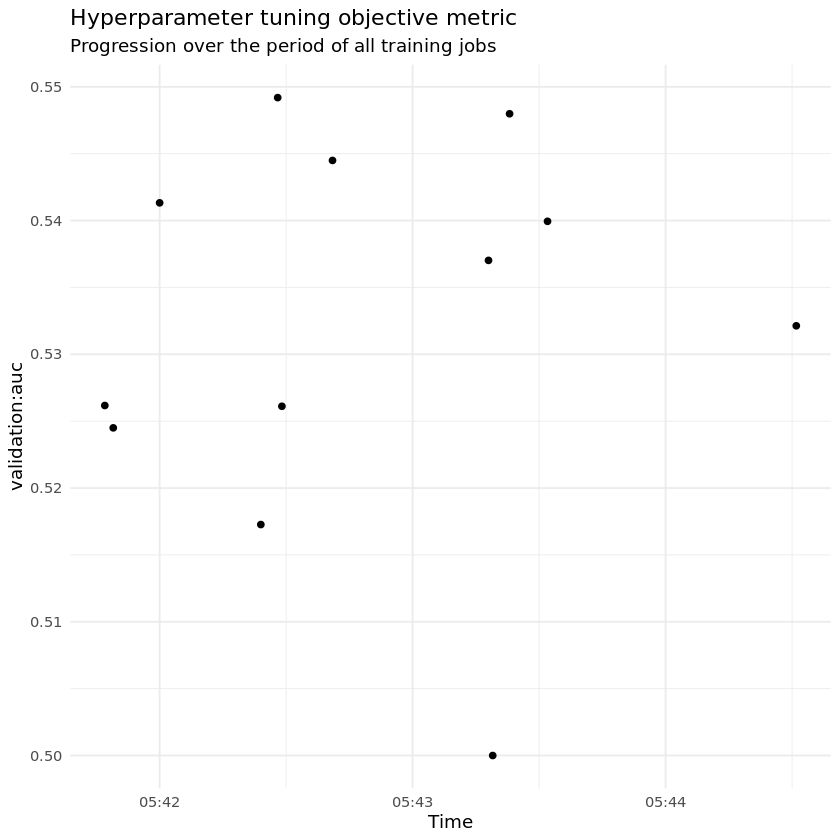

In [103]:
ggplot(tuning_results_df, aes(TrainingEndTime, FinalObjectiveValue)) +
  geom_point() +
  xlab("Time") +
  ylab(tuning_job_results$description()$TrainingJobDefinition$StaticHyperParameters$`_tuning_objective_metric`) +
  ggtitle("Hyperparameter tuning objective metric",  
          "Progression over the period of all training jobs") +
  theme_minimal()

In [104]:
best_tuned_model <- tuning_results_df %>%
  filter(FinalObjectiveValue == max(FinalObjectiveValue)) %>%
  pull(TrainingJobName)
best_tuned_model

[1] "tune-xgboost-20230314-05-39-22-005-773ed971"

In [105]:
training_job_stats <- session$describe_training_job(job_name = best_tuned_model)

final_metrics <-  map_df(training_job_stats$FinalMetricDataList, 
                          ~tibble(metric_name = .x[["MetricName"]],
                                  value = .x[["Value"]]))
final_metrics

metric_name,value
<chr>,<dbl>
validation:auc,0.549194
train:auc,0.589726
ObjectiveMetric,0.549194


In [82]:
predictions_path <- paste0("s3://", bucket, "/", project_name, "/", model_name, "/", 'models')

predictions_path

[1] "s3://sagemaker-us-east-1-758761341410/ML-MADNESS/elo-small-1/models"